# Example 4a: Textured Si cell

In this example, we will introduce RayFlare, which is a package which is closely interlinked with Solcore and extends its optical capabilities. One of the features it has is a ray-tracer, which is useful when modelling e.g. Si solar cells with textured surfaces. We will compare the result with PVLighthouse's [wafer ray tracer](https://www2.pvlighthouse.com.au/calculators/wafer%20ray%20tracer/wafer%20ray%20tracer.html).

For more information on how ray-tracing works, see [RayFlare's documentation](https://rayflare.readthedocs.io/en/latest/Theory/theory.html).

In [11]:
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from rayflare.ray_tracing import rt_structure
from rayflare.textures import regular_pyramids, planar_surface
from rayflare.options import default_options
from rayflare.utilities import make_absorption_function

from solcore.absorption_calculator import search_db
from solcore import material, si
from solcore.solar_cell import SolarCell, Layer, Junction
from solcore.solar_cell_solver import solar_cell_solver
from solcore.solar_cell_solver import default_options as defaults_solcore

## Setting up

First, setting up Solcore materials. We use a specific set of Si optical constants from [this paper](https://doi.org/10.1016/j.solmat.2008.06.009).
These are included in the refractiveindex.info database, so we take them from there. This is the same data we used for the [PVLighthouse](https://www2.pvlighthouse.com.au/calculators/wafer%20ray%20tracer/wafer%20ray%20tracer.html) calculation which we are going to compare to.

In [12]:
Air = material('Air')()
Si_Green = search_db("Si/Green-2008")[0][0]
Si_RT = material(str(Si_Green), nk_db=True)()

Database file found at /Users/phoebe/.solcore/nk/nk.db
1 results found.
pageid	shelf	book	page	filepath	hasrefractive	hasextinction	rangeMin	rangeMax	points
687	main	Si	Green-2008	main/Si/Green-2008.yml	1	1	0.25	1.45	121


The `calc` variable is a switch: if True, run the calculation; if False, load the result of the previous calculation. Will need to run at least once to
generate the results!

We use this 'switch' to avoid re-running the whole ray-tracing calculation (which can be time-consuming) each time we
want to look at the results.

In [13]:
calc = True

Setting options:

In [14]:
wl = np.linspace(300, 1201, 50) * 1e-9
options = default_options()
options.wavelengths = wl

# setting up some colours for plotting
pal = sns.color_palette("husl", 4)

`nx` and `ny` are the number of point to scan across in the x & y directions in the unit cell. Decrease this to speed up the calculation (but increase noise in results). We also
set the total number of rays traced, and depth spacing for the absorption profile calculation.

In [15]:
nxy = 25
options.nx = nxy
options.ny = nxy
options.n_rays = 4 * nxy ** 2 # Number of rays to be traced at each wavelength:
options.depth_spacing = si('50nm') # depth spacing for the absorption profile
options.parallel = True  # this is the default - if you do not want the code to run in parallel, change to False

Load the result of the PVLighthouse calculation for comparison:

In [16]:
PVlighthouse = np.loadtxt('data/RAT_data_300um_2um_55.csv', delimiter=',', skiprows=1)

Define surface for the ray-tracing: a planar surface, and a surface with regular pyramids.

In [17]:
flat_surf = planar_surface(size=2) # pyramid size in microns
triangle_surf = regular_pyramids(55, upright=False, size=2)

Set up the ray-tracing structure: this is a list of textures of length n, and then a list of materials of length n-1. So far a single layer, we define a front surface and a back surface (n = 2), and specify the material in between those two surfaces (n-1 = 1). We also specify the width of each material, and the incidence medium (above the first interface) and the transmission medium (below the last interface.

In [18]:
rtstr = rt_structure(textures=[triangle_surf, flat_surf],
                    materials = [Si_RT],
                    widths=[si('300um')], incidence=Air, transmission=Air)

## Running ray-tracing calculation

Run the calculation, if `calc` was set to True, otherwise load the results. We save the reflection, transmission, and total absorption in an array called `result_RAT` and the absorption profile as `profile_rt`.

In [19]:
#| output: false

if calc:
    # This executes if calc = True (set at the top of the script): actually run the ray-tracing:
    result = rtstr.calculate_profile(options)

    # Put the results (Reflection, front surface reflection, transmission, absorption in the Si) in an array:
    result_RAT = np.vstack((options['wavelengths']*1e9,
                        result['R'], result['R0'], result['T'], result['A_per_layer'][:,0])).T

    # absorption profile:
    profile_rt = result['profile']

    # save the results:
    np.savetxt('results/rayflare_fullrt_300um_2umpyramids_300_1200nm.txt', result_RAT)
    np.savetxt('results/rayflare_fullrt_300um_2umpyramids_300_1200nm_profile.txt', result['profile'])

else:
    # If calc = False, load results from previous run.
    result_RAT = np.loadtxt('results/rayflare_fullrt_300um_2umpyramids_300_1200nm.txt')
    profile_rt = np.loadtxt('results/rayflare_fullrt_300um_2umpyramids_300_1200nm_profile.txt')

Database file found at /Users/phoebe/.solcore/nk/nk.db
Material main/Si/Green-2008.yml loaded.
Database file found at /Users/phoebe/.solcore/nk/nk.db
Material main/Si/Green-2008.yml loaded.


**PLOT 1**: results of ray-tracing from RayFlare and PVLighthouse, showing the reflection, absorption and transmission.

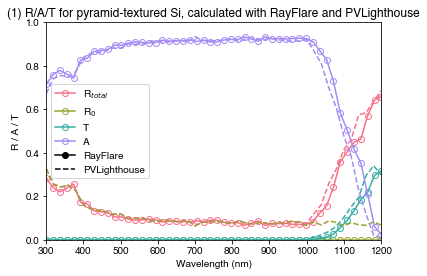

In [20]:
plt.figure()
plt.plot(result_RAT[:,0], result_RAT[:,1], '-o', color=pal[0], label=r'R$_{total}$', fillstyle='none')
plt.plot(result_RAT[:,0], result_RAT[:,2], '-o', color=pal[1], label=r'R$_0$', fillstyle='none')
plt.plot(result_RAT[:,0], result_RAT[:,3], '-o', color=pal[2], label=r'T', fillstyle='none')
plt.plot(result_RAT[:,0], result_RAT[:,4], '-o', color=pal[3], label=r'A', fillstyle='none')
plt.plot(PVlighthouse[:, 0], PVlighthouse[:, 2], '--', color=pal[0])
plt.plot(PVlighthouse[:, 0], PVlighthouse[:, 9], '--', color=pal[2])
plt.plot(PVlighthouse[:, 0], PVlighthouse[:, 3], '--', color=pal[1])
plt.plot(PVlighthouse[:, 0], PVlighthouse[:, 5], '--', color=pal[3])
plt.plot(-1, -1, '-ok', label='RayFlare')
plt.plot(-1, -1, '--k', label='PVLighthouse')
plt.xlabel('Wavelength (nm)')
plt.ylabel('R / A / T')
plt.ylim(0, 1)
plt.xlim(300, 1200)
plt.legend()
plt.title("(1) R/A/T for pyramid-textured Si, calculated with RayFlare and PVLighthouse")
plt.show()

## Using optical results in Solcore

So far, we have done a purely optical calculation; however, if we want to use this information to do an EQE or IV calculation, we can, by using the ability of Solcore to accept external optics data (we used this in [Example 1a](1a-simple_cell.ipynb) already). To use Solcore's device simulation capabilities (QE/IV), we need to create a function which gives the depth-dependent absorption profile. The argument of the function is the position (in m) in the cell, which can be an array, and the function returns an array with the absorption at these depths at every wavelength with dimensions (n_wavelengths, n_positions).

RayFlare has the make_absorption_function to automatically make this function, as required by Solcore, from RayFlare's output data. `diff_absorb_fn` here is the function we need to pass to Solcore (so it is not an array of values!). We need to provide the profile data, the structure that was being simulated, user options and specify whether we used the angular redistribution matrix method (which in this case we did not, so we set `matrix_method=False`; see [Example 6a]](6a-multiscale_models.ipynb) for a similar example which does use this method).

In [21]:
position, diff_absorb_fn = make_absorption_function(profile_rt, rtstr, options, matrix_method=False)

Now we feed this into Solcore; we will define a solar cell model using the depletion approximation (see [Example 1c](1c-simple_cell.ipynb)).

We need a p-n junction; we make sure the total width of the p-n junction is equal to the width of the Si used above
in the ray-tracing calculation (`rtrst.widths[0]`).


In [22]:
Si_base = material("Si")

n_material_Si_width = si("500nm")
p_material_Si_width = rtstr.widths[0] - n_material_Si_width

n_material_Si = Si_base(Nd=si(1e21, "cm-3"), hole_diffusion_length=si("10um"),
                electron_mobility=50e-4, relative_permittivity=11.68)
p_material_Si = Si_base(Na=si(1e16, "cm-3"), electron_diffusion_length=si("290um"),
                hole_mobility=400e-4, relative_permittivity=11.68)

Options for Solcore (note that these are separate from the RayFlare options we set above!):

In [23]:
options_sc = defaults_solcore
options_sc.optics_method = "external"
options_sc.position = np.arange(0, rtstr.width, options.depth_spacing)
options_sc.light_iv = True
options_sc.wavelength = wl
options_sc.theta = options.theta_in*180/np.pi
V = np.linspace(0, 1, 200)
options_sc.voltages = V

Make the solar cell, passing the absorption function we made above, and the reflection (an array with the R value at each wavelength), and calculate the QE and I-V characteristics.

In [24]:
solar_cell = SolarCell(
    [
        Junction([Layer(width=n_material_Si_width, material=n_material_Si, role='emitter'),
                  Layer(width=p_material_Si_width, material=p_material_Si, role='base')],
                 sn=1, sp=1, kind='DA')
    ],
    external_reflected=result_RAT[:,1],
    external_absorbed=diff_absorb_fn)

solar_cell_solver(solar_cell, 'qe', options_sc)
solar_cell_solver(solar_cell, 'iv', options_sc)

Solving optics of the solar cell...
Solving QE of the solar cell...
Solving optics of the solar cell...
Already calculated reflection, transmission and absorption profile - not recalculating. Set recalculate_absorption to True in the options if you want absorption to be calculated again.
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


**PLOT 2**: EQE and absorption of Si cell with optics calculated through ray-tracing

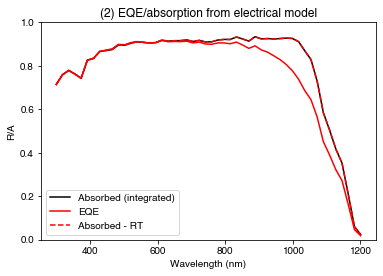

In [25]:
plt.figure()
plt.plot(wl*1e9, solar_cell.absorbed, 'k-', label='Absorbed (integrated)')
plt.plot(wl*1e9, solar_cell[0].eqe(wl), 'r-', label='EQE')
plt.plot(wl*1e9, result_RAT[:,4], 'r--', label='Absorbed - RT')
plt.ylim(0,1)
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('R/A')
plt.title("(2) EQE/absorption from electrical model")
plt.show()

**PLOT 3**: Light IV of Si cell with optics calculated through ray-tracing

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


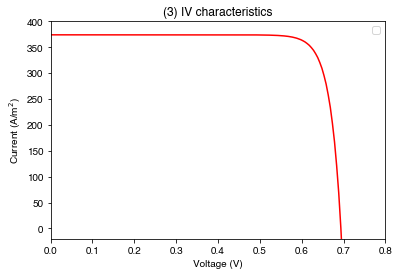

In [26]:
plt.figure()
plt.plot(V, -solar_cell[0].iv(V), 'r')
plt.ylim(-20, 400)
plt.xlim(0, 0.8)
plt.legend()
plt.ylabel('Current (A/m$^2$)')
plt.xlabel('Voltage (V)')
plt.title("(3) IV characteristics")
plt.show()